# Watson Girdle fit for Euler pole poition prior

In [1]:
import os
import numpy as np
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.special as sp
from scipy.stats import norm

from bayesian_pep import *

import pmagpy.ipmag as ipmag

import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dbname = 'data/euler_pole_prior.pickle'

def generate_data_samples(n_samples=100):

    plate_id_to_code = { 0 : 'an',
                         1 : 'au',
                         2 : 'nb',
                         3 : 'pa',
                         4 : 'eu',
                         5 : 'na',
                         6 : 'nz',
                         7 : 'co',
                         8 : 'ca',
                         9 : 'ar',
                        10 : 'ps',
                        11 : 'sa',
                        12 : 'in',
                        13 : 'jf' }


    morvel = pd.read_table("data/NNR-MORVEL56.txt", delim_whitespace=True).set_index('Abbreviation')
    plate_data = np.loadtxt("data/WhichPlate.dat")
    vals = plate_data[:,2]

    nlons = 256
    nlats = 128
    dlon = 360./nlons
    dlat = 180./nlats

#         print(vals)
    vals = np.reshape(vals, (nlats,nlons))

    val_samples = np.zeros(n_samples)
    lon_samples = np.zeros(n_samples)
    lat_samples = np.zeros(n_samples)

    with pm.Model() as model:
        uniform_lon_lat_sampler = VMF('lon_lat_sampler', lon_lat = [0.,0.], k = 0., testval = np.array([1., 0.]), shape = 2)

    i=0
    while i < n_samples:
        sample = uniform_lon_lat_sampler.random()
        lon = sample[0]
        lat = sample[1]
        try:
            lon_index = np.floor(lon/dlon)
            lat_index = np.floor((90.-lat)/dlat)
            plate_id = vals[int(lat_index), int(lon_index)]
            plate_code = plate_id_to_code[plate_id]

            elat = morvel['Latitude'][plate_code]
            elon = morvel['Longitude'][plate_code]

            evec = spherical_to_cartesian( elon, elat, 1.)
            x = spherical_to_cartesian( lon, lat, 1.)

            lon_samples[i] = lon
            lat_samples[i] = lat
            val_samples[i] =  np.arccos(np.dot(x, evec))*180./np.pi
            i += 1
        except KeyError:
            continue
#     print(lon_samples,lat_samples,val_samples)
    np.savetxt('data/euler_pole_samples.txt', [lon_samples,lat_samples,val_samples])

    return lon_samples,lat_samples,val_samples

In [5]:
# Sample position/angular-distance for current plate configuration
lon_samples,lat_samples,val_samples = generate_data_samples(5000)

In [6]:
# Generate a girdle distribution from those samples,
# where the longitude should not matter when calculating
# the log likelihood.
lon_lat = np.array([ [ random.random()*360., 90.-sample] for sample in val_samples])
lon_lat2 = np.array([ [ random.random()*360., sample-90] for sample in val_samples])
lon_lat = np.vstack([lon_lat, lon_lat2])

In [7]:
lon_lat.shape

(10000, 2)

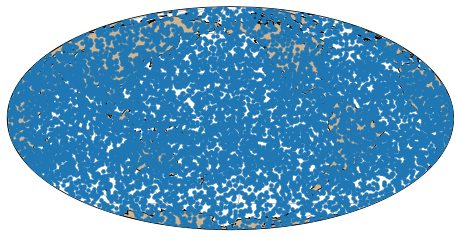

In [7]:
ax = ipmag.make_mollweide_map(200)
ipmag.plot_vgp(ax, lon_lat.T[0], lon_lat.T[1], color='C0', edge='none')

In [8]:
with pm.Model() as model:

    concentration = pm.Uniform('concentration', 0., 2.)
#     for i in range(lon_lat.shape[0]):
    angular_distance = WatsonGirdle('angular_distance_', lon_lat=np.array([0., 90.]), k= -1*concentration, observed=lon_lat)

    trace = pm.sample(10000, tune=2000, compute_convergence_checks=1, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
Slice: [concentration]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 43042 seconds.


In [9]:
pm.save_trace(trace, 'code_output/euler_prior_trace', overwrite=1)

'code_output/euler_prior_trace'

In [ ]:
# trace_saved = pm.load_trace('code_output/euler_prior_trace', model)

In [17]:
trace_df = pm.trace_to_dataframe(trace)

In [18]:
trace_df.to_csv('code_output/euler_prior_trace.csv')

In [3]:
trace = pd.read_csv('code_output/euler_prior_trace.csv')

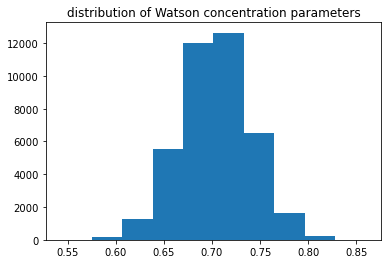

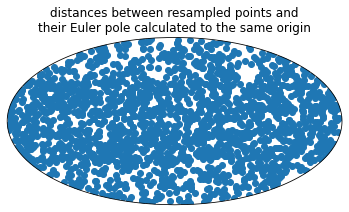

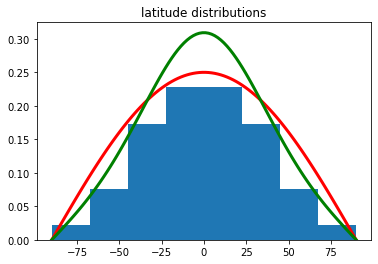

In [19]:
#pymc.Matplot.trace(db.trace('concentration'))
concentration_trace = trace['concentration']
plt.hist( concentration_trace )
plt.title('distribution of Watson concentration parameters')
plt.show()

ax = plt.axes( projection=ccrs.Mollweide(0.) )
ax.set_global()
interval = 5
ax.scatter(lon_lat[::interval,0],lon_lat[::interval,1], transform=ccrs.PlateCarree())
plt.title('distances between resampled points and\ntheir Euler pole calculated to the same origin')
plt.show()

n_samples = len(lon_lat[:,1])
uniform_x = np.linspace(0., np.pi, 100)
uniform_y = np.sin(uniform_x)/2. 
kappa =  -0.7#hidden_concentration
watson_x = np.linspace(0., np.pi, 100)
watson_y = 1./sp.hyp1f1(0.5,1.5,kappa) * np.exp(kappa * np.cos(watson_x)**2.)*np.sin(watson_x)/2. 

bins = np.linspace(-90., 90., 9)
plt.hist( lon_lat[:,1], bins=bins, weights=np.ones_like(lon_lat[:,1])/n_samples, density=0)
plt.plot( 90.-uniform_x*180./np.pi, uniform_y/2, 'r', lw=3)
plt.plot( 90.-watson_x*180./np.pi, watson_y/2, 'g', lw=3)
plt.title('latitude distributions')
plt.show()

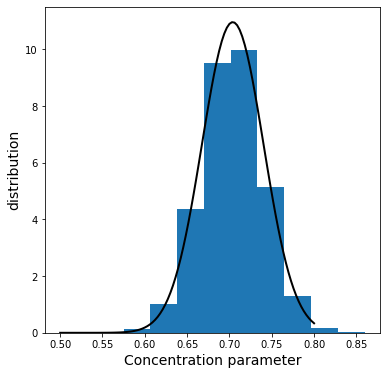

In [11]:
mu, std = norm.fit(concentration_trace)

plt.figure(figsize=(6,6))
plt.hist(concentration_trace, color='C0', density=1)
x = np.linspace(0.5,.8, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.ylabel('distribution', fontsize=14)
plt.xlabel('Concentration parameter', fontsize=14)
plt.show()

In [12]:
mu, std

(0.7039126611338136, 0.03639452142670446)